<div>
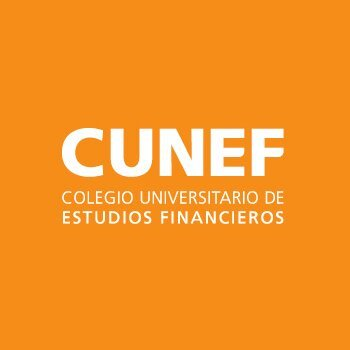
</div>

# **Número de vuelos de pasajeros en España**

En este notebook se mostrará la serie temporal del **número de vuelos de pasajeros en España** y observaremos cómo afectó ésta frente al COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura del archivo y preparación de datos
    3) Graficación de la serie temporal original
    4) Modelo de suavizado exponencial (ETS)
    5) Modelo autorregresivo integrado de media móvil (ARIMA)
    6) Tipos de outliers
    7) Función de transferencia
    8) Causal Impact y Prophet

## *Librerías*

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

In [5]:
# nuevas librerías aquí
from prophet import Prophet
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

## *Lectura del csv y preparación de los datos*

Se procede a la lectura del CSV del tráfico aéreo en España, ofrecidos por AENA.
- Fuente: https://www.aena.es/es/estadisticas/inicio.html

In [32]:
df_vuelos = pd.read_excel("vuelos.xlsx")
df_vuelos = df_vuelos.set_index("Periodo")
df_vuelos

,Total Pasajeros,Total Mercancías
Periodo,,
2014-01-01,10959721,51279738
2014-02-01,10779086,51395821
2014-03-01,13446155,60074235
2014-04-01,16246439,55234845
2014-05-01,17540838,56289587
...,...,...
2022-02-01,11908046,78764432
2022-03-01,15587273,92308548
2022-04-01,20458260,82681716


In [33]:
df_vuelos=df_vuelos.drop('Total Mercancías', axis=1)
df_vuelos

,Total Pasajeros
Periodo,
2014-01-01,10959721
2014-02-01,10779086
2014-03-01,13446155
2014-04-01,16246439
2014-05-01,17540838
...,...
2022-02-01,11908046
2022-03-01,15587273
2022-04-01,20458260


## *Graficación de la serie temporal*

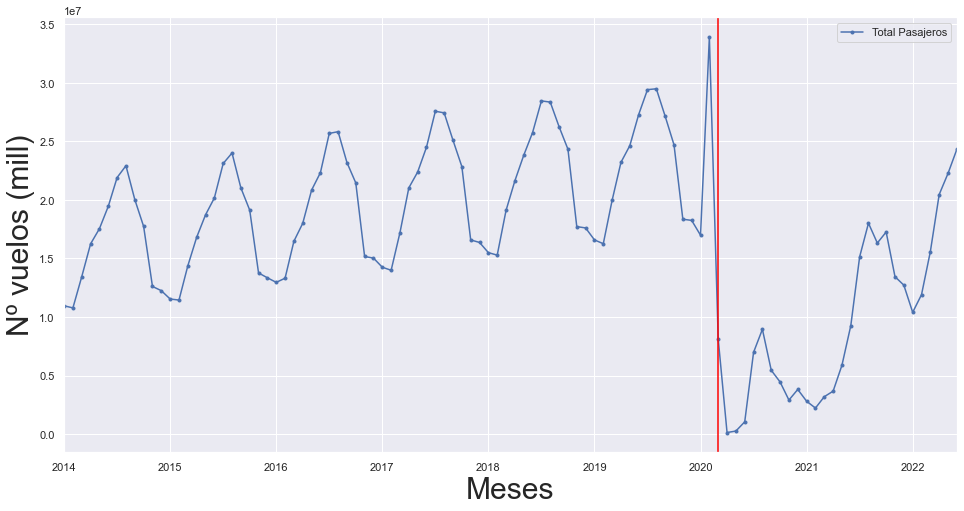

In [16]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(16, 8)})
fig = df_vuelos.plot(marker='.') 
fig.set_ylabel('Nº vuelos (mill)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);

En común podemos apreciar que existía una tendencia creciente hasta la época COVID, en la que se redujeron el número de vuelos tanto en pasajeros como en mercancías, en cambio parece estar recuperando los números. 

Por otra parte, en el total de pasajeros se puede apreciar una clara estacionalidad marcada por los meses de verano, fechas en las que hay mucha gente que se mueve a otros lugares para pasar las vacaciones. Para el total de mercancías se irá viendo a lo largo de los siguientes ploteos. 


A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza tanto de pasajeros como de mercancías
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [19]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [24]:
media=split_and_summarize(df_vuelos,'Total Pasajeros',4,np.mean)
varianza=split_and_summarize(df_vuelos,'Total Pasajeros',4,np.var)

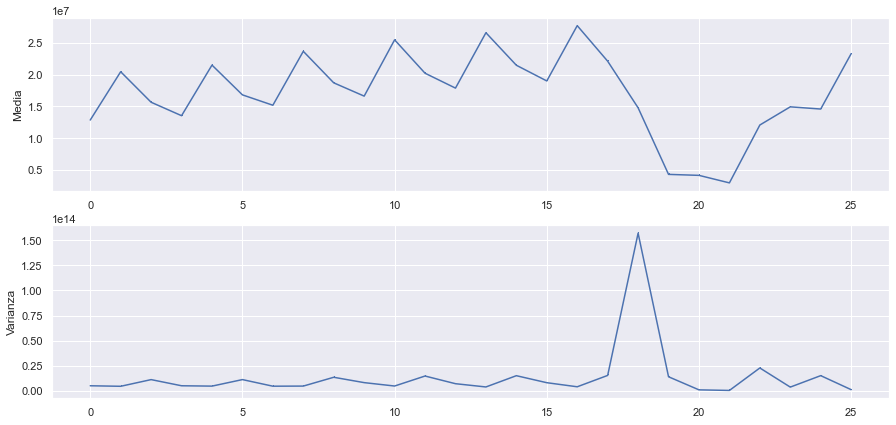

In [26]:
cols=['media','varianza']
df=pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')


plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

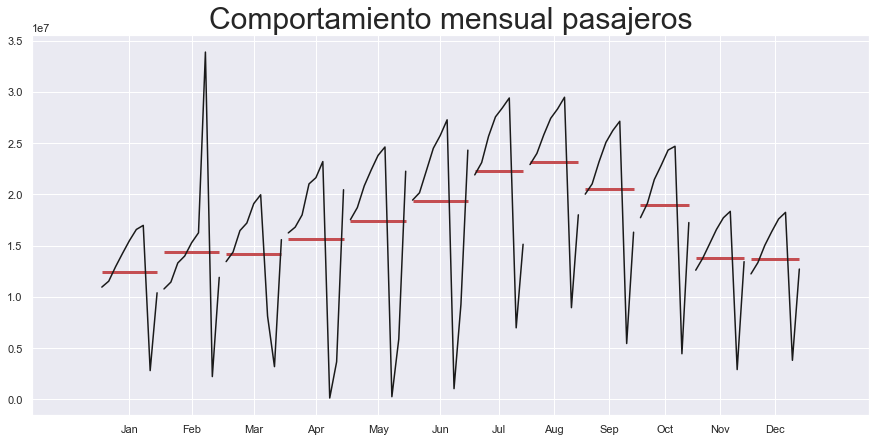

In [27]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_vuelos['Total Pasajeros'], ax = ax)
ax.set_title('Comportamiento mensual pasajeros', fontsize = 30);

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

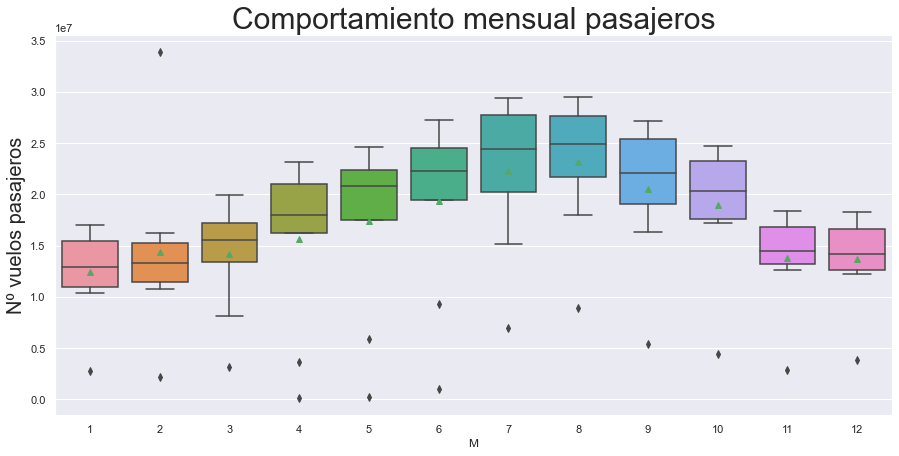

In [9]:
df_vuelos['M'] = df_vuelos.index.month
sns.boxplot(data = df_vuelos, x = 'M', y='Total Pasajeros', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Nº vuelos pasajeros', fontsize = 20)
ax.set_title('Comportamiento mensual pasajeros', fontsize = 30);

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

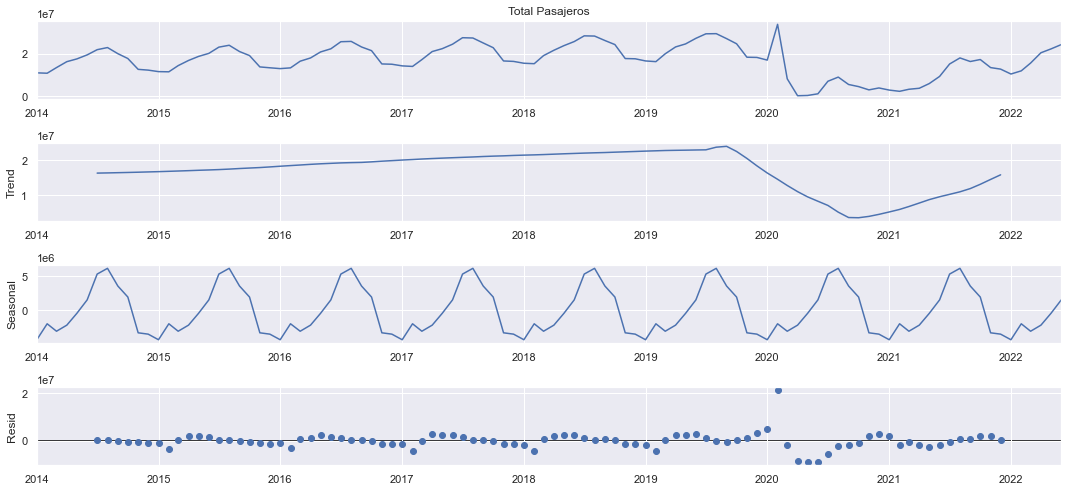

In [28]:
desglose_pasajeros = seasonal_decompose(df_vuelos['Total Pasajeros'], 
                                   model='additive', 
                                   period=12);

desglose_pasajeros.plot();

Analizando las gráficas, observamos:

- En referencia al total de pasajeros, lo mismo que se dijo al principio: estacionalidad marcada, tendencia creciente hasta el momento COVID, aunque con claros rasgos de recuperación. Es una serie temporal estacionaria ya que su media y su varianza son regulares a lo largo del periodo a pesar de que lo desbalanceara el COVID-19.
- En cuanto al total de mercancías, la tendencia es igual que con el total de pasajeros, y la estacionalidad no es muy clara y es irregular. Parece que es una serie temporal estacionaria ya que su media y varianza es constante a lo largo del tiempo (suprimiendo el incremento en el momento COVID-19)

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.